In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

from xhistogram.xarray import histogram

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://10.148.0.99:35573' processes=0 threads=0, memory=0 B>

## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
DL =100*1e3 #meters
DT = 3*3600 #seconds

In [4]:
l = labels[0]
dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[var+['drogue_status', 'alti___distance', 'alti___time_difference']].dropna('obs').chunk({'obs':500})
dsm = dsm.where(dsm.alti___distance<=DL, drop=True)
dsm = dsm.where(dsm.alti___time_difference<=DT, drop=True).drop(['alti___distance', 'alti___time_difference'])
dsm = match.add_except_sum(dsm)   
nb = dsm.sizes["obs"]

In [8]:
dsm = dsm.reset_coords(['lon', 'lat', 'time']).drop(['id_comb', 'time'])

In [19]:
dsm = dsm.isel(obs=slice(0,1000))

In [108]:
dsm = dsm.drop('time')

In [109]:
dfm =dsm.to_dataframe()
dfm["latbin"] = (dfm.lat // dl) * dl
dfm["lonbin"] = (dfm.lon // dl) * dl
dfms = (dfm**2).groupby(["latbin", "lonbin"]).mean()

In [110]:
dfms

e5_cstrio_z0_alti_wd_x  e5_cstrio_z0_drifter_wd_x  \
latbin lonbin                                                       
0.0    0.0                2.076681e-15               1.358639e-15   
       400.0              4.525703e-16               8.802382e-16   
       1600.0             9.986412e-13               1.205536e-12   
       3600.0             6.034168e-13               7.309737e-13   
       6400.0             5.553206e-13               8.522229e-13   
       10000.0            1.039811e-17               1.746909e-14   
       14400.0            8.937224e-13               1.367121e-12   
       19600.0            2.830046e-12               2.676212e-12   
       25600.0            5.164088e-12               4.821794e-12   
       32400.0            1.164636e-11               1.134254e-11   
400.0  0.0                3.521818e-13               1.059928e-13   
       400.0              2.313171e-11               2.193111e-11   
       1600.0             5.135497e-12               4.978837e-12   
       3600.0             3.662498e-11               4.135733e-11   
       6400.0             6.313861e-12               6.404358e-12   
       10000.0            1.292605e-12               1.020354e-12   
       14400.0            7.872445e-12               4.986977e-12   
       19600.0            3.904105e-11               3.916908e-11   
       25600.0            7.535396e-11               8.853676e-11   
       32400.0            2.082236e-11               1.334903e-11   
1600.0 0.0                5.192641e-12               6.938133e-12   
       400.0              1.122148e-10               9.906225e-11   
       1600.0             1.187091e-10               9.956382e-11   
       3600.0             1.337261e-10               1.503967e-10   
       6400.0             1.945225e-11               1.844364e-11   
       10000.0            1.742420e-11               1.544468e-11   
       14400.0            6.295287e-12               6.157051e-12   
       19600.0            6.643840e-11               7.250963e-11   
       25600.0            6.191172e-11               6.801345e-11   
       32400.0            1.125937e-10               6.342823e-11   
3600.0 0.0                8.439997e-10               8.736040e-10   
       400.0              6.668243e-10               6.153580e-10   
       1600.0             4.356358e-10               3.731008e-10   
       3600.0             2.376262e-10               2.013835e-10   
       6400.0             9.039807e-11               9.129389e-11   
       10000.0            1.379986e-10               1.500570e-10   
       14400.0            2.048698e-10               1.989935e-10   
       19600.0            2.313931e-10               2.209283e-10   
       25600.0            3.183489e-11               3.249357e-11   
       32400.0            3.000184e-10               2.538222e-10   
6400.0 400.0              9.909490e-12               2.041551e-11   
       1600.0             2.801814e-11               5.466682e-12   
       6400.0             1.563889e-12               1.403742e-12   
       10000.0            1.426839e-11               1.496713e-11   

                e5_cstrio_z15_alti_wd_x  e5_cstrio_z15_drifter_wd_x  \
latbin lonbin                                                         
0.0    0.0                 6.099680e-16                5.932927e-16   
       400.0               7.272633e-17                1.716164e-16   
       1600.0              8.186661e-14                1.043234e-13   
       3600.0              7.950580e-14                9.636820e-14   
       6400.0              3.273018e-14                4.335870e-14   
       10000.0             4.312044e-17                2.322281e-15   
       14400.0             1.933064e-13                2.742145e-13   
       19600.0             2.672970e-13                2.462180e-13   
       25600.0             5.779739e-13                5.171545e-13   
       32400.0             1.108498e-12                1.062

# LON LAT bins

In [28]:
dl = 20
lon_bin, lat_bin = np.arange(-180, 180, dl), np.arange(-90,90,dl)
bins_lonlat =[lon_bin,lat_bin]

min_coloc_bin = 50

# PDFs
acc_bins=np.arange(-1e-4,1e-4,1e-5)
#acc_bins1=np.arange(-5e-3,5e-3,1e-5)

bins_list = {"acc": acc_bins,'lat':lat_bin}

In [89]:
lon_bin+dl/2

array([-170., -150., -130., -110.,  -90.,  -70.,  -50.,  -30.,  -10.,
         10.,   30.,   50.,   70.,   90.,  110.,  130.,  150.,  170.])

In [93]:
np.arange(lon_bin.size*lat_bin.size).reshape(( lat_bin.size,lon_bin.size))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17],
       [ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35],
       [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53],
       [ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107],
       [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125],
       [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161]])

In [98]:
lonlat = xr.DataArray(np.arange(lon_bin.size*lat_bin.size).reshape(( lat_bin.size,lon_bin.size)), coords={'lat_bin':lat_bin+dl/2, 'lon_bin':lon_bin+dl/2})

In [99]:
lonlat

<xarray.DataArray (lat_bin: 9, lon_bin: 18)>
array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17],
       [ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35],
       [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53],
       [ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107],
       [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125],
       [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161]])
Coordinates:
  * lat_bin  (lat_bin) float64 -80.0 -60.0 -40.0 -20.0 0.0 20.0 40.0 60.0 80.0
  * lon_bin  (lon_bin) float64 -170.0 -150.0 -130.0 -110.0 ... 130.0 150.0 170.0

In [101]:
dsm['central_lon'] = dsm.lon//dl*dl +dl/2
dsm['central_lat'] = dsm.lat//dl*dl +dl/2
dsm['central_bin'] = lonlat.sel(lon_bin=dsm.central_lon, lat_bin=dsm.central_lat)

Task exception was never retrieved
future: <Task finished name='Task-1482712' coro=<Client._gather.<locals>.wait() done, defined at /home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1482713' coro=<Client._gather.<locals>.wait() done, defined at /home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='

KeyError: "not all values found in index 'lat_bin'"

In [79]:
d = np.transpose([np.array(dsm['central_lon']), np.array(dsm['central_lon'])])

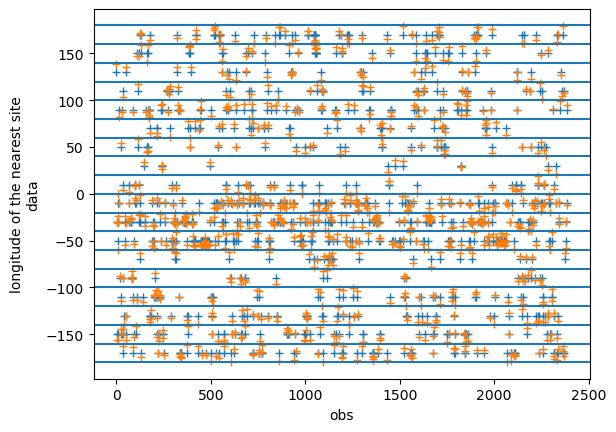

In [54]:
dsm.central_lon.plot(ls='', marker='+')
dsm.lon.plot(ls='', marker='+')
for l in np.arange(-180, 200, dl) :
    plt.axhline(l)

In [62]:
dfm = dsm.isel(obs=slice(0,10)).to_dataframe()
dfm.grupby(

e5_cstrio_z0_alti_wd_x  e5_cstrio_z0_drifter_wd_x  \
obs                                                      
0             -1.559022e-06              -2.237023e-06   
5             -2.702177e-06              -2.442015e-06   
6             -8.859952e-06              -8.333424e-06   
7              5.555995e-06               5.291029e-06   
8             -9.184030e-06              -1.122761e-05   
9              4.520149e-07               4.507143e-07   
10            -1.369773e-06              -1.541725e-06   
11            -7.415367e-06              -2.046010e-05   
13             3.093675e-09              -7.641190e-08   
17            -4.306863e-06              -3.967339e-06   

     e5_cstrio_z15_alti_wd_x  e5_cstrio_z15_drifter_wd_x  \
obs                                                        
0              -3.970133e-07               -5.051500e-07   
5              -7.541277e-07               -7.177974e-07   
6              -3.684774e-06               -3.331778e-06   
7               2.413384e-06                2.293038e-06   
8              -3.758087e-06               -4.528834e-06   
9               1.723666e-07                1.700854e-07   
10             -5.742498e-07               -6.310798e-07   
11             -8.113255e-06               -1.327898e-05   
13              3.290971e-09                3.155366e-08   
17             -2.706942e-06               -2.547414e-06   

     es_cstrio_z0_alti_wd_x  es_cstrio_z0_drifter_wd_x  \
obs                                                      
0             -1.960798e-06              -2.237023e-06   
5             -2.710466e-06              -2.494596e-06   
6             -8.182292e-06              -8.308214e-06   
7              5.671290e-06               5.768976e-06   
8             -9.750848e-06              -1.045542e-05   
9              3.946267e-07               4.507143e-07   
10            -1.184080e-06              -1.235855e-06   
11            -7.200034e-06              -1.978255e-05   
13            -4.278173e-08              -1.061409e-07   
17            -3.720750e-06              -3.557598e-06   

     es_cstrio_z15_alti_wd_x  es_cstrio_z15_drifter_wd_x  \
obs                                                        
0              -5.507893e-07               -5.051500e-07   
5              -7.481535e-07               -7.285037e-07   
6              -3.401500e-06               -3.341775e-06   
7               2.401216e-06                2.412514e-06   
8              -4.007627e-06               -4.211338e-06   
9               1.504828e-07                1.700854e-07   
10             -4.863138e-07               -4.859836e-07   
11             -7.905659e-06               -1.282953e-05   
13              4.665178e-08                4.383003e-08   
17             -2.357365e-06               -2.297475e-06   

     e5_cstrio_z0_alti_wd_y  e5_cstrio_z0_drifter_wd_y  ...  \
obs                                                     ...   
0             -1.731991e-06              -3.010367e-06  ...   
5             -2.464252e-06              -1.931166e-06  ...   
6              1.794836e-06               5.966882e-07  ...   
7             -1.962115e-06              -1.825934e-06  ...   
8              1.359835e-06               1.129285e-06  ...   
9              3.557648e-08               5.011376e-08  ...   
10             3.147399e-07               2.300174e-07  ...   
11             4.246013e-05               4.299884e-05  ...   
13            -1.696450e-08              -5.004171e-07  ...   
17             8.330479e-06               8.114105e-06  ...   

     sum_aviso__0__adt__e5_cstrio_z0__drifter_y  \
obs                                               
0                                 -3.240457e-05   
5                                 -1.458493e-05   
6                                 -6.122802e-07   
7                                  1.624992e-06   
8                                  1.471276e-06   
9                                 -1.880460e-05   
10  

In [60]:
dsm_multiindex = dsm.stack({'obs'dsm.central_lon,dsm.central_lat})

ValueError: the first argument to .stack must be a dictionary

In [59]:
dsm.stack?

Signature:
dsm.stack(
    dimensions: 'Mapping[Any, Sequence[Hashable]]' = None,
    **dimensions_kwargs: 'Sequence[Hashable]',
) -> 'Dataset'
Docstring:
Stack any number of existing dimensions into a single new dimension.

New dimensions will be added at the end, and the corresponding
coordinate variables will be combined into a MultiIndex.

Parameters
----------
dimensions : mapping of hashable to sequence of hashable
    Mapping of the form `new_name=(dim1, dim2, ...)`. Names of new
    dimensions, and the existing dimensions that they replace. An
    ellipsis (`...`) will be replaced by all unlisted dimensions.
    Passing a list containing an ellipsis (`stacked_dim=[...]`) will stack over
    all dimensions.
**dimensions_kwargs
    The keyword arguments form of ``dimensions``.
    One of dimensions or dimensions_kwargs must be provided.

Returns
-------
stacked : Dataset
    Dataset with stacked data.

See Also
--------
Dataset.unstack
File:      ~/.miniconda3/envs/histenv2/lib/py

In [29]:
def compute_pdfs(ds, bins):
    """Compute and add to the diagnosis dataset independant pdf of the acceleration's, coriolis's terms for both x-along track and y-orthogonal direction and pressure gradient's term on both x-along track
    If the given bin is np.ndarray, it returns the pdfs of the flatten ds, if the given bin is a dictionnary, the pdfs will be computed along dict dimensions.

    Parameters
    ----------
    ds : xarray Dataset
        dataset build by box.build_dataset
    bins : np.ndarray or dict('dim':ndarray)
    ds_diag : xarray Dataset
        diagnosis dataset in which we add new diagnosis
    """
    ds_diag = xr.Dataset()
    list_var = list(ds.keys())
    # bins = dict(acc=bins_acc, separation=bins_separation)

    # Acceleration
    dt = 3600
    if isinstance(bins, dict):
        for var in list_var:
            ds_diag["pdf_" + var] = (
                histogram(
                    ds[var].rename("acc"),
                    *[ds[k] for k in bins if k != "acc"],
                    bins=[v for k, v in bins.items()],
                    density=True
                )
                .compute()
            )

    elif isinstance(bins, np.ndarray):
        for var in list_var:
            ds_diag["pdf_" + var] = (
                histogram(ds[var].rename("acc"), bins=bins, density=True)
                .compute()
            )
    else:
        print("wrong bins type")

    ds_diag["nb_coloc"] = ds.sizes["obs"]
    if "id_comb" in ds:
        ds_diag["id_comb"] = ds["id_comb"]
    
    ds_diag.acc_bin.attrs={'longname':'accbins', 'units':r'$m.s^{-2}$'}

    return ds_diag

In [30]:
ds_ = compute_pdfs(dsm, bins_list)

Task exception was never retrieved
future: <Task finished name='Task-219508' coro=<Client._gather.<locals>.wait() done, defined at /home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


In [24]:
ds_

<xarray.Dataset>
Dimensions:                                                                    (
                                                                                acc_bin: 19,
                                                                                lon_bin: 17)
Coordinates:
  * acc_bin                                                                    (acc_bin) float64 ...
  * lon_bin                                                                    (lon_bin) float64 ...
Data variables: (12/438)
    pdf_e5_cstrio_z0_alti_wd_x                                                 (acc_bin, lon_bin) float64 ...
    pdf_e5_cstrio_z0_drifter_wd_x                                              (acc_bin, lon_bin) float64 ...
    pdf_e5_cstrio_z15_alti_wd_x                                                (acc_bin, lon_bin) float64 ...
    pdf_e5_cstrio_z15_drifter_wd_x                                             (acc_bin, lon_bin) float64 ...
    pdf_es_cstrio_z0_alti_wd_x                                                 (acc_bin, lon_bin) float64 ...
    pdf_es_cstrio_z0_drifter_wd_x                                              (acc_bin, lon_bin) float64 ...
    ...                                                                         ...
    pdf_sum_aviso__0__adt__es_cstrio_z15__drifter_y                            (acc_bin, lon_bin) float64 ...
    pdf_sum_aviso__0__sla__e5_cstrio_z0__drifter_y                             (acc_bin, lon_bin) float64 ...
    pdf_sum_aviso__0__sla__e5_cstrio_z15__drifter_y                            (acc_bin, lon_bin) float64 ...
    pdf_sum_aviso__0__sla__es_cstrio_z0__drifter_y                             (acc_bin, lon_bin) float64 ...
    pdf_sum_aviso__0__sla__es_cstrio_z15__drifter_y                            (acc_bin, lon_bin) float64 ...
    nb_coloc                                                                   int64 ...

In [ ]:
# nb coloc/bins
ds_repart = xr.concat([diag.coloc_repartition(dsm, bins= bins_lonlat) for l in DS.keys()], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_repart = ds_repart.where(ds_repart!=0, np.nan)

ds_repart_all = ds_repart.sum(dim='drifter_sat_year')

In [6]:
# nb coloc/bins
ds_repart = xr.concat([diag.coloc_repartition(DS[l], bins= bins_lonlat) for l in DS.keys()], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_repart = ds_repart.where(ds_repart!=0, np.nan)

ds_repart_all = ds_repart.sum(dim='drifter_sat_year')

print(1)

# PDFs
acc_bins=np.arange(-1e-4,1e-4,1e-6)
acc_bins1=np.arange(-5e-3,5e-3,1e-5)

bins_list = {"acc": acc_bins, "lon" : lon_bin, "lat": lat_bin}
ds_pdf = xr.concat([diag.compute_pdfs(DS[key], bins_list) for key in DS], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_pdf['nb_coloc_bins']=ds_repart.assign_attrs({'description':'number of colocalisations per bins', 'long_name':'colocalisations/bins'})
ds_pdf.attrs = {'description':'pdf for erastar, labels[:2], with alti__time_difference<1h', 'lonlatbin':dl, 'min_coloc_bin': min_coloc_bin}

1


In [7]:
ds_pdf

<xarray.Dataset>
Dimensions:                                                        (
                                                                    acc_bin: 200,
                                                                    lon_bin: 71,
                                                                    lat_bin: 35,
                                                                    drifter_sat_year: 2,
                                                                    id_comb: 36)
Coordinates:
  * acc_bin                                                        (acc_bin) float64 ...
  * lon_bin                                                        (lon_bin) float64 ...
  * lat_bin                                                        (lat_bin) float64 ...
  * id_comb                                                        (id_comb) <U44 ...
  * drifter_sat_year                                               (drifter_sat_year) object ...
Data variables: (12/187)
    pdf_alti_g_grad_x                                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_alti_denoised_g_grad_x                                     (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_x                                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_y                                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_x                                         (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_y                                         (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    ...                                                             ...
    pdf_sum_aviso_es_cstrio_z0_alti_y                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_alti_y                             (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z0_drifter_y                           (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_drifter_y                          (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    nb_coloc                                                       (drifter_sat_year) int64 ...
    nb_coloc_bins                                                  (drifter_sat_year, lon_bin, lat_bin) float64 ...
Attributes:
    description:    pdf for erastar, labels[:2], with alti__time_difference<1h
    lonlatbin:      5
    min_coloc_bin:  50

In [8]:
zarr = os.path.join(zarr_dir, f"pdf_lonlat_bin{dl}_sentinel_saral_gps.zarr")
ds_pdf.to_zarr(zarr, mode="w")  
print(f"pdf storred in {zarr}")

pdf storred in /home1/datawork/mdemol/m2/pdf_lonlat_bin5_sentinel_saral_gps.zarr


In [9]:
ds_pdf_all = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sum('drifter_sat_year')/(ds_pdf.nb_coloc.sum('drifter_sat_year'))#normalized
ds_pdf_all['nb_coloc_bins'] = ds_pdf.nb_coloc_bins.sum('drifter_sat_year')
ds_pdf_all['id_comb'] = ds_pdf['id_comb']
ds_pdf_all = ds_pdf_all.where(ds_pdf_all.nb_coloc_bins>=min_coloc_bin)
for v in ds_pdf_all : 
    ds_pdf_all[v].attrs = ds_pdf[v].attrs
ds_pdf_all

<xarray.Dataset>
Dimensions:                                                        (
                                                                    acc_bin: 200,
                                                                    lon_bin: 71,
                                                                    lat_bin: 35,
                                                                    id_comb: 36)
Coordinates:
  * acc_bin                                                        (acc_bin) float64 ...
  * lon_bin                                                        (lon_bin) float64 ...
  * lat_bin                                                        (lat_bin) float64 ...
  * id_comb                                                        (id_comb) <U44 ...
Data variables: (12/186)
    pdf_alti_g_grad_x                                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_alti_denoised_g_grad_x                                     (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_x                                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_y                                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_x                                         (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_y                                         (acc_bin, lon_bin, lat_bin) float64 ...
    ...                                                             ...
    pdf_sum_co_adt_oceantide_dac_es_cstrio_z15_drifter_x           (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z0_alti_y                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_alti_y                             (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z0_drifter_y                           (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_drifter_y                          (acc_bin, lon_bin, lat_bin) float64 ...
    nb_coloc_bins                                                  (lon_bin, lat_bin) float64 ...

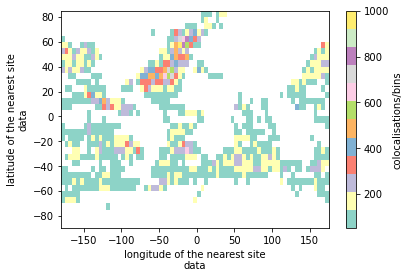

In [10]:
ds_pdf_all.nb_coloc_bins.plot(x='lon_bin', y='lat_bin', cmap='Set3')

In [11]:
ds_std_all = diag.ds_mean_var_std(ds_pdf_all,'acc_bin', mean=True, var=True, rms=True)

In [12]:
ds_std_all

<xarray.Dataset>
Dimensions:                                                         (
                                                                     lon_bin: 71,
                                                                     lat_bin: 35,
                                                                     id_comb: 36)
Coordinates:
  * lon_bin                                                         (lon_bin) float64 ...
  * lat_bin                                                         (lat_bin) float64 ...
  * id_comb                                                         (id_comb) <U44 ...
Data variables: (12/926)
    mean_alti_g_grad_x                                              (lon_bin, lat_bin) float64 ...
    var_alti_g_grad_x                                               (lon_bin, lat_bin) float64 ...
    std_alti_g_grad_x                                               (lon_bin, lat_bin) float64 ...
    rms_alti_g_grad_x                                               (lon_bin, lat_bin) float64 ...
    ms_alti_g_grad_x                                                (lon_bin, lat_bin) float64 ...
    mean_alti_denoised_g_grad_x                                     (lon_bin, lat_bin) float64 ...
    ...                                                              ...
    mean_sum_aviso_es_cstrio_z15_drifter_y                          (lon_bin, lat_bin) float64 ...
    var_sum_aviso_es_cstrio_z15_drifter_y                           (lon_bin, lat_bin) float64 ...
    std_sum_aviso_es_cstrio_z15_drifter_y                           (lon_bin, lat_bin) float64 ...
    rms_sum_aviso_es_cstrio_z15_drifter_y                           (lon_bin, lat_bin) float64 ...
    ms_sum_aviso_es_cstrio_z15_drifter_y                            (lon_bin, lat_bin) float64 ...
    nb_coloc_bins                                                   (lon_bin, lat_bin) float64 ...

In [13]:
zarr = os.path.join(zarr_dir, f"stat_lonlat_bin{dl}_lim{min_coloc_bin}_sentinel_saral_gps.zarr")
ds_std_all.to_zarr(zarr, mode="w")  
print(f"diag storred in {zarr}")

diag storred in /home1/datawork/mdemol/m2/stat_lonlat_bin5_lim50_sentinel_saral_gps.zarr


In [21]:
cluster.close()